In [1]:
import pandas as pd
import numpy as  np

from TargetEncoderv2 import TargetEncoder
from FeatureSelector import FeatureSelector

from sklearn.metrics import *
from sklearn.model_selection import *

import lightgbm as lgb
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# create a file handler
handler = logging.FileHandler('featureset1.log')
handler.setLevel(logging.INFO)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)

In [2]:
def cvFeatureGeneration(df, folds=10, cols=None, targetcol='is_attributed', func='mean', cname=None):
    cvlist = StratifiedKFold(folds, random_state=1).split(df, df[targetcol])
    enc = TargetEncoder(cols=cols, targetcol=targetcol, func=func, cname=cname, add_to_orig=False)
    df[cname] = cross_val_predict(enc, df, df[targetcol], cv=cvlist, method='transform', verbose=0, pre_dispatch=None)
    return df

def testFeatureGeneration(train, test, cols=None, targetcol='is_attributed', func='mean', cname=None):
    enc = TargetEncoder(cols=cols, targetcol=targetcol, func=func, cname=cname, add_to_orig=False)
    test[cname] = enc.fit(train).transform(test)
    return test

def getTimeFeats(df):
    df["click_time"] = pd.to_datetime(df["click_time"])
    df["hourofday"] = df["click_time"].dt.hour.astype(np.uint16)
    df["dayofweek"] = df["click_time"].dt.weekday.astype(np.uint8)
    del df['click_time']
    return df


In [3]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }
    

In [4]:
train = pd.read_csv("../input/train_sample.csv")


In [5]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [6]:
train = getTimeFeats(train)

In [8]:
#ip hour channel day var
col_name = "ip_hour_channel_dayvar"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','hourofday','channel'], targetcol='dayofweek', func='var', cname=col_name, add_to_orig=False)
train[col_name] = enc.fit_transform(train)
logger.info("Stats for generated feature for train are {}".format(train[col_name].describe()))

INFO:__main__:processing feature ip_hour_channel_dayvar for train
INFO:__main__:Stats for generated feature for train are count    3745.000000
mean        0.560191
std         0.661828
min         0.000000
25%         0.000000
50%         0.500000
75%         0.500000
max         2.000000
Name: ip_hour_channel_dayvar, dtype: float64


In [9]:
#ip hour day count
col_name = "ip_hour_day_count"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','hourofday','dayofweek'], targetcol='channel', func='count', cname=col_name, add_to_orig=False)
train[col_name] = enc.fit_transform(train)
logger.info("Stats for generated feature for train are {}".format(train[col_name].describe()))

INFO:__main__:processing feature ip_hour_day_count for train
INFO:__main__:Stats for generated feature for train are count    100000.000000
mean          1.493280
std           2.020593
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          28.000000
Name: ip_hour_day_count, dtype: float64


In [10]:
#ip hour day channel count
col_name = "ip_day_channel_hourvar"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','dayofweek', 'channel'], targetcol='hourofday', func='var', cname=col_name, add_to_orig=False)
train[col_name] = enc.fit_transform(train)
logger.info("Stats for generated feature for train are {}".format(train[col_name].describe()))

INFO:__main__:processing feature ip_day_channel_hourvar for train
INFO:__main__:Stats for generated feature for train are count    10877.000000
mean        28.060797
std         33.822226
min          0.000000
25%          4.500000
50%         18.000000
75%         39.555556
max        264.500000
Name: ip_day_channel_hourvar, dtype: float64


In [11]:
#Add priors and count for getting confidence on them
CVFOLDS = 20 ##Decrease to 10 folds

for ftype in ['count', 'mean']:
    for col in ['ip', 'app', 'device', 'os', 'channel', 'hourofday', ['ip','app'],
               ['app', 'device'], ['app', 'os'], ['app', 'channel'], ['app', 'hourofday'],
               ['device', 'hourofday'], ['os', 'hourofday'], ['channel', 'hourofday'],
               ['channel', 'os'], ['os', 'hourofday'], ['channel', 'hourofday']]:

        if isinstance(col, list):
            cols = col
            #col_name = ''
            col_name = '_'.join(cols)
            col_name = col_name + "_" + ftype
        elif isinstance(col, str):
            cols = [col]
            col_name = col + "_" + ftype
        logger.info("processing feature {} for train".format(col_name))
        train = cvFeatureGeneration(train, folds=CVFOLDS, cols=cols, func=ftype, cname=col_name)
        logger.info("Stats for generated feature for train are {}".format(train[col_name].describe()))



INFO:__main__:processing feature ip_count for train
INFO:__main__:Stats for generated feature for train are count    81860.000000
mean        28.337405
std         89.316893
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max        647.000000
Name: ip_count, dtype: float64
INFO:__main__:processing feature app_count for train
INFO:__main__:Stats for generated feature for train are count    99959.000000
mean      8918.909593
std       5527.525489
min          1.000000
25%       2985.000000
50%       8530.000000
75%      12534.000000
max      17440.000000
Name: app_count, dtype: float64
INFO:__main__:processing feature device_count for train
INFO:__main__:Stats for generated feature for train are count    99930.000000
mean     84789.666587
std      19847.464022
min          1.000000
25%      89602.000000
50%      89617.000000
75%      89629.000000
max      89676.000000
Name: device_count, dtype: float64
INFO:__main__:processing feature os_count for

INFO:__main__:Stats for generated feature for train are count    99377.000000
mean         0.001974
std          0.025809
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: app_os_mean, dtype: float64
INFO:__main__:processing feature app_channel_mean for train
INFO:__main__:Stats for generated feature for train are count    99925.000000
mean         0.002187
std          0.025674
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000134
max          1.000000
Name: app_channel_mean, dtype: float64
INFO:__main__:processing feature app_hourofday_mean for train
INFO:__main__:Stats for generated feature for train are count    99595.000000
mean         0.002009
std          0.023337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: app_hourofday_mean, dtype: float64
INFO:__main__:processing feature device_hourofday_mean for train
INF

In [13]:
logger.info("Writing out train file")
train.to_csv("../input/train_featureset1_v2.csv", index=False, compression='gzip')

INFO:__main__:Writing out train file


In [14]:
test = pd.read_csv("../input/test.csv")###TO RUN ON FULL DATA
test = getTimeFeats(test)

In [15]:
#ip hour channel day var
col_name = "ip_hour_channel_dayvar"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','hourofday','channel'], targetcol='dayofweek', func='var', cname=col_name, add_to_orig=False)
test[col_name] = enc.fit_transform(test)
logger.info("Stats for generated feature for train are {}".format(test[col_name].describe()))

#ip hour day count
col_name = "ip_hour_day_count"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','hourofday','dayofweek'], targetcol='channel', func='count', cname=col_name, add_to_orig=False)
test[col_name] = enc.fit_transform(test)
logger.info("Stats for generated feature for train are {}".format(test[col_name].describe()))

#ip hour day channel count
col_name = "ip_day_channel_hourvar"
logger.info("processing feature {} for train".format(col_name))
enc = TargetEncoder(cols=['ip','dayofweek', 'channel'], targetcol='hourofday', func='var', cname=col_name, add_to_orig=False)
test[col_name] = enc.fit_transform(test)
logger.info("Stats for generated feature for train are {}".format(test[col_name].describe()))


INFO:__main__:processing feature ip_hour_channel_dayvar for train
INFO:__main__:Stats for generated feature for train are count    15206665.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: ip_hour_channel_dayvar, dtype: float64
INFO:__main__:processing feature ip_hour_day_count for train
INFO:__main__:Stats for generated feature for train are count    1.879047e+07
mean     1.133618e+03
std      4.505620e+03
min      1.000000e+00
25%      6.200000e+01
50%      1.310000e+02
75%      3.120000e+02
max      4.023100e+04
Name: ip_hour_day_count, dtype: float64
INFO:__main__:processing feature ip_day_channel_hourvar for train
INFO:__main__:Stats for generated feature for train are count    1.793867e+07
mean     1.172614e+01
std      6.301252e+00
min      0.000000e+00
25%      8.191176e+00
50%      1.236111e+01
75%      1.494368e+01
max      6.050000e+01
Name: ip_day_channel_hourvar, dtype: float

In [16]:
for ftype in ['count', 'mean']:
    for col in ['ip', 'app', 'device', 'os', 'channel', 'hourofday', ['ip','app'],
               ['app', 'device'], ['app', 'os'], ['app', 'channel'], ['app', 'hourofday'],
               ['device', 'hourofday'], ['os', 'hourofday'], ['channel', 'hourofday'],
               ['channel', 'os'], ['os', 'hourofday'], ['channel', 'hourofday']]:
        if isinstance(col, list):
            cols = col
            #col_name = ''
            col_name = '_'.join(cols)
            col_name = col_name + "_" + ftype
        elif isinstance(col, str):
            cols = [col]
            col_name = col + "_" + ftype
        logger.info("processing feature {} for test".format(col_name))
        test = testFeatureGeneration(train, test, cols=cols, func=ftype, cname=col_name) 
        logger.info("Stats for generated feature for test are {}".format(test[col_name].describe()))


INFO:__main__:processing feature ip_count for test
INFO:__main__:Stats for generated feature for test are count    1.453070e+07
mean     3.458561e+01
std      1.086509e+02
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.200000e+01
max      6.690000e+02
Name: ip_count, dtype: float64
INFO:__main__:processing feature app_count for test
INFO:__main__:Stats for generated feature for test are count    1.876480e+07
mean     8.501127e+03
std      5.441467e+03
min      1.000000e+00
25%      2.422000e+03
50%      8.992000e+03
75%      1.173700e+04
max      1.827900e+04
Name: app_count, dtype: float64
INFO:__main__:processing feature device_count for test
INFO:__main__:Stats for generated feature for test are count    1.869124e+07
mean     8.787003e+04
std      2.336324e+04
min      1.000000e+00
25%      9.433800e+04
50%      9.433800e+04
75%      9.433800e+04
max      9.433800e+04
Name: device_count, dtype: float64
INFO:__main__:processing feature os_count for test


INFO:__main__:processing feature app_channel_mean for test
INFO:__main__:Stats for generated feature for test are count    1.856993e+07
mean     3.025738e-03
std      2.859810e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: app_channel_mean, dtype: float64
INFO:__main__:processing feature app_hourofday_mean for test
INFO:__main__:Stats for generated feature for test are count    1.870625e+07
mean     3.351613e-03
std      2.572846e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: app_hourofday_mean, dtype: float64
INFO:__main__:processing feature device_hourofday_mean for test
INFO:__main__:Stats for generated feature for test are count    1.866713e+07
mean     2.919129e-03
std      1.607257e-02
min      0.000000e+00
25%      8.770007e-04
50%      1.366120e-03
75%      1.929012e-03
max      1.000000e+00
Name: device_hourofday_mean, dtype: float64

In [17]:
logger.info("Writing out test file")
test.to_csv("../input/test_featureset1_v2.csv", index=False, compression='gzip')

INFO:__main__:Writing out test file


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
train.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'attributed_time',
       'is_attributed', 'hourofday', 'dayofweek', 'ip_hour_channel_dayvar',
       'ip_hour_day_count', 'ip_day_channel_hourvar', 'ip_count', 'app_count',
       'device_count', 'os_count', 'channel_count', 'hourofday_count',
       'ip_app_count', 'app_device_count', 'app_os_count', 'app_channel_count',
       'app_hourofday_count', 'device_hourofday_count', 'os_hourofday_count',
       'channel_hourofday_count', 'channel_os_count', 'ip_mean', 'app_mean',
       'device_mean', 'os_mean', 'channel_mean', 'hourofday_mean',
       'ip_app_mean', 'app_device_mean', 'app_os_mean', 'app_channel_mean',
       'app_hourofday_mean', 'device_hourofday_mean', 'os_hourofday_mean',
       'channel_hourofday_mean', 'channel_os_mean'],
      dtype='object')

In [20]:
test.columns

Index(['click_id', 'ip', 'app', 'device', 'os', 'channel', 'hourofday',
       'dayofweek', 'ip_hour_channel_dayvar', 'ip_hour_day_count',
       'ip_day_channel_hourvar', 'ip_count', 'app_count', 'device_count',
       'os_count', 'channel_count', 'hourofday_count', 'ip_app_count',
       'app_device_count', 'app_os_count', 'app_channel_count',
       'app_hourofday_count', 'device_hourofday_count', 'os_hourofday_count',
       'channel_hourofday_count', 'channel_os_count', 'ip_mean', 'app_mean',
       'device_mean', 'os_mean', 'channel_mean', 'hourofday_mean',
       'ip_app_mean', 'app_device_mean', 'app_os_mean', 'app_channel_mean',
       'app_hourofday_mean', 'device_hourofday_mean', 'os_hourofday_mean',
       'channel_hourofday_mean', 'channel_os_mean'],
      dtype='object')

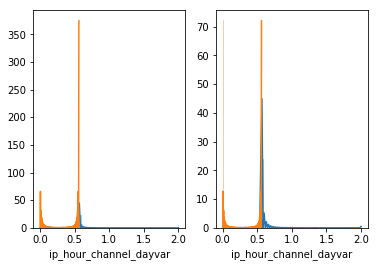

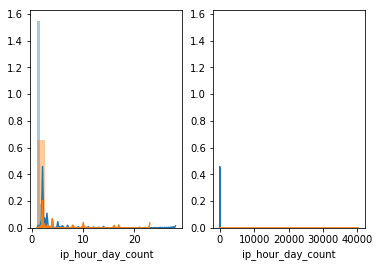

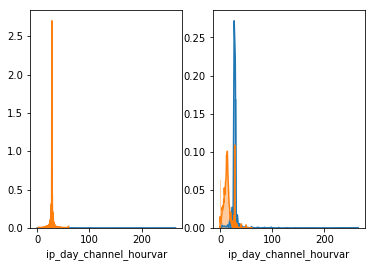

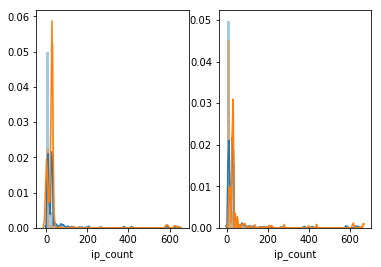

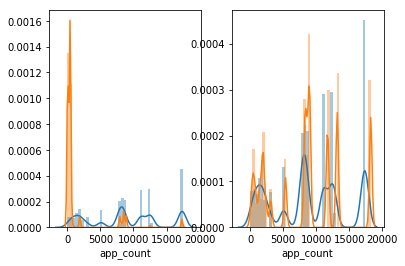

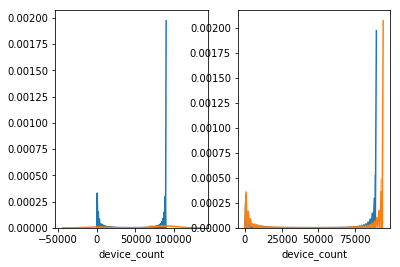

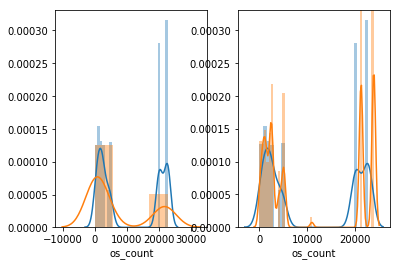

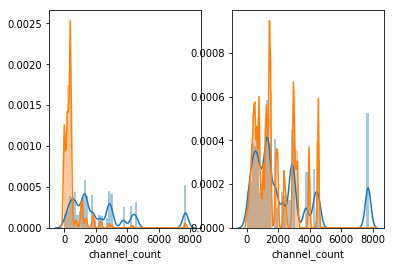

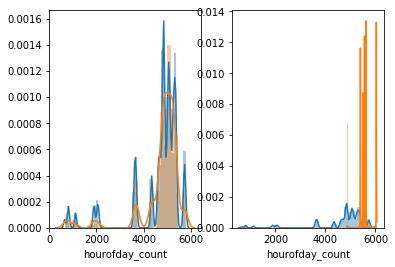

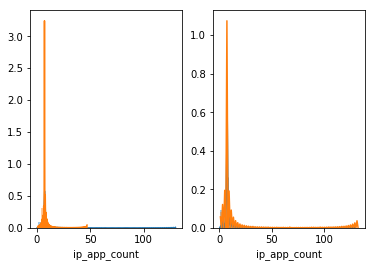

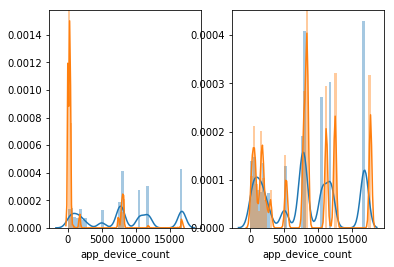

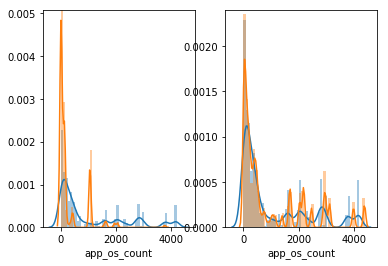

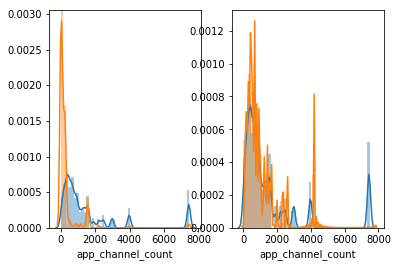

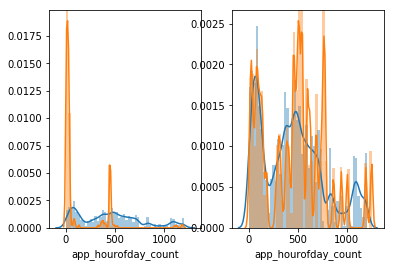

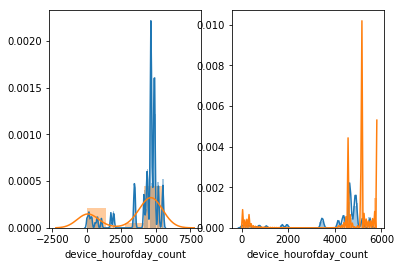

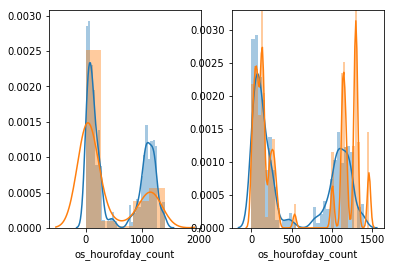

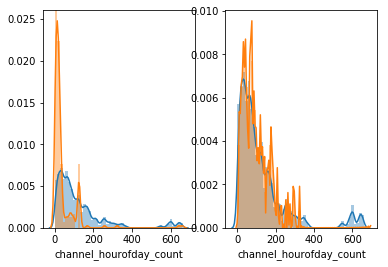

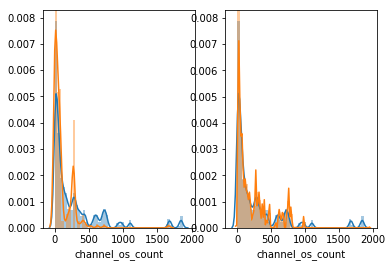

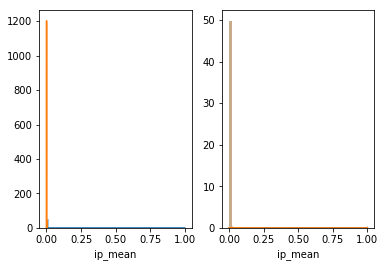

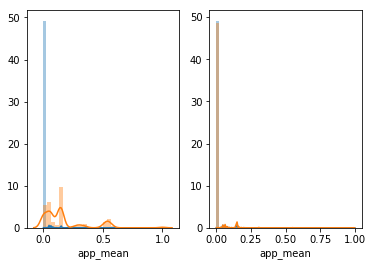

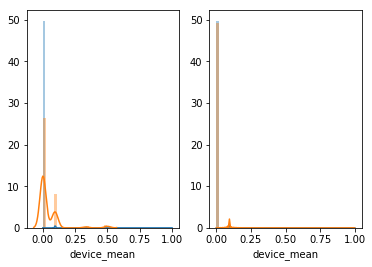

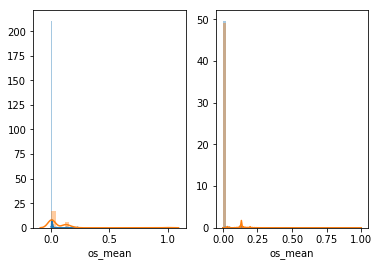

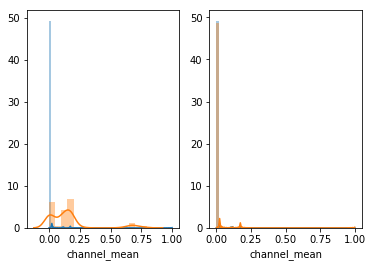

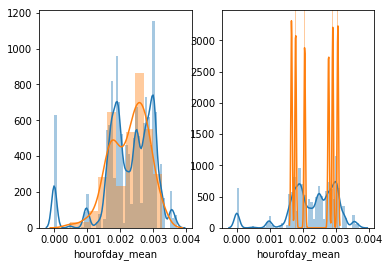

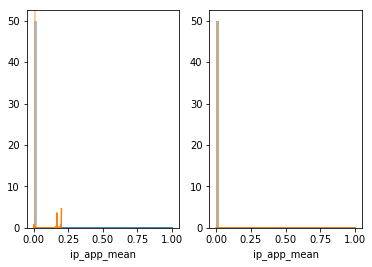

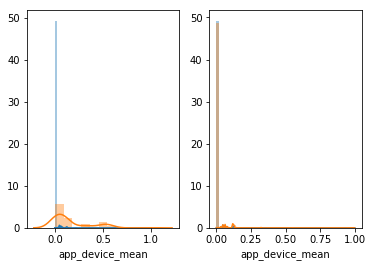

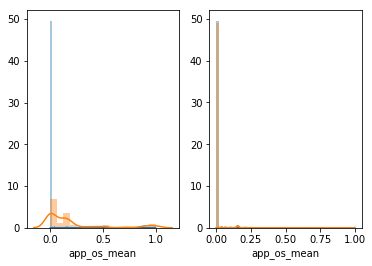

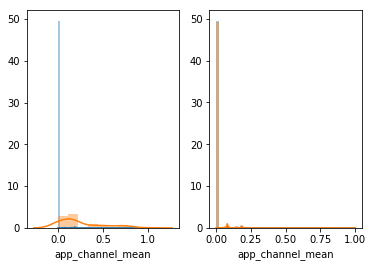

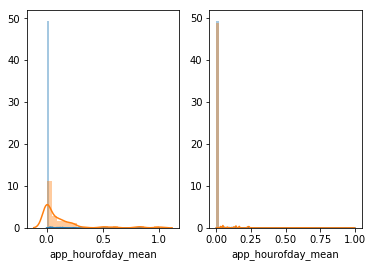

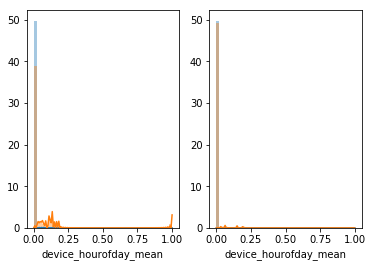

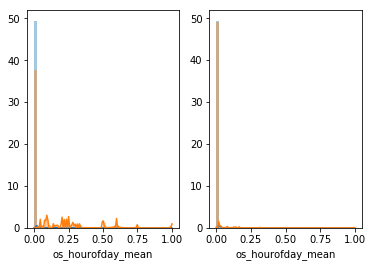

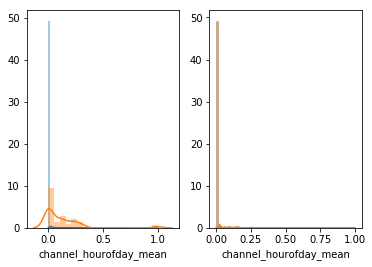

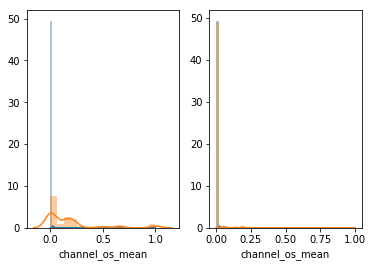

In [21]:
feats = ['ip_hour_channel_dayvar',
       'ip_hour_day_count', 'ip_day_channel_hourvar', 'ip_count', 'app_count',
       'device_count', 'os_count', 'channel_count', 'hourofday_count',
       'ip_app_count', 'app_device_count', 'app_os_count', 'app_channel_count',
       'app_hourofday_count', 'device_hourofday_count', 'os_hourofday_count',
       'channel_hourofday_count', 'channel_os_count', 'ip_mean', 'app_mean',
       'device_mean', 'os_mean', 'channel_mean', 'hourofday_mean',
       'ip_app_mean', 'app_device_mean', 'app_os_mean', 'app_channel_mean',
       'app_hourofday_mean', 'device_hourofday_mean', 'os_hourofday_mean',
       'channel_hourofday_mean', 'channel_os_mean']

for col in feats:
    plt.subplot(1,2,1)
    sns.distplot(train.loc[train.is_attributed == 0, col].fillna(train[col].mean()))
    sns.distplot(train.loc[train.is_attributed == 1, col].fillna(train[col].mean()))
    
    plt.subplot(1,2,2)
    sns.distplot(train[col].fillna(train[col].mean()))
    sns.distplot(test[col].fillna(train[col].mean()))
    plt.show()

In [22]:
#ip_app_count, device_count, ip_day_channel_hourvar, ip_hour_day_count, ip_hour_channel_dayvar
train.loc[train.is_attributed ==1, 'ip_hour_channel_dayvar'].describe()

count    2.000000
mean     0.166667
std      0.235702
min      0.000000
25%      0.083333
50%      0.166667
75%      0.250000
max      0.333333
Name: ip_hour_channel_dayvar, dtype: float64

In [23]:
train.loc[train.is_attributed ==0, 'ip_hour_channel_dayvar'].describe()

count    3743.000000
mean        0.560401
std         0.661932
min         0.000000
25%         0.000000
50%         0.500000
75%         0.500000
max         2.000000
Name: ip_hour_channel_dayvar, dtype: float64

In [24]:
train.loc[train.is_attributed == 0, 'ip_day_channel_hourvar'].describe()

count    10871.000000
mean        28.060015
std         33.828889
min          0.000000
25%          4.500000
50%         18.000000
75%         39.555556
max        264.500000
Name: ip_day_channel_hourvar, dtype: float64